In [228]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
import torch

In [229]:
fixed_image=np.load('/home-local/rudravg/test_DAPI/1024_Dataset_V2/target_images/GCA112TIA_GCA112TIA_0_0_2048.npy')
moving_image=np.load('/home-local/rudravg/test_DAPI/1024_Dataset_V2/source_images/GCA112TIA_GCA112TIA_17_0_2048.npy')

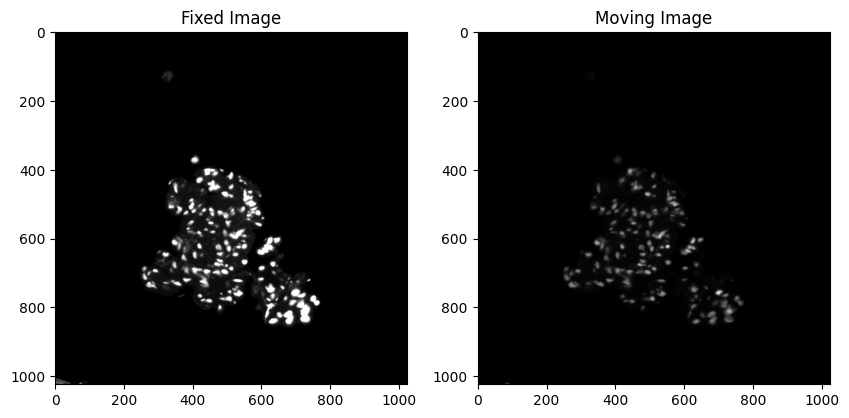

In [230]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the fixed image
axs[0].imshow(fixed_image, cmap='gray')
axs[0].set_title('Fixed Image')

# Display the moving image
axs[1].imshow(moving_image, cmap='gray')
axs[1].set_title('Moving Image')

# Show the plot
plt.show()

In [231]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#trial2_epochs/epoch_113/epoch_113.pth -> 0.001
#Inc_smoothness_epochs_v2/epoch_20/epoch_20.pth -> 0.01
#Smoothness_0.1_epochs/epoch_20/epoch_20.pth -> 0.1
#Smoothness_1_epochs/epoch_15/epoch_15.pth -> 1
best_model_path='/home-local/rudravg/test_DAPI/1024_Dataset_V2/Smoothness_10_epochs/epoch_10/epoch_10.pth'
#best_model_path='/home-local/rudravg/test_DAPI/Smoothness_0.1_epochs/epoch_20/epoch_20.pth'
best_model=vxm.networks.VxmDense.load(best_model_path, device)
best_model.to(device)
best_model.eval()

VxmDense(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2-3): 2 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1-3): 3 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(64, 32, kerne

In [232]:
#moving_block = moving_block[np.newaxis, ..., np.newaxis]
fixed_image = fixed_image[np.newaxis, ..., np.newaxis]
moving_image = moving_image[np.newaxis, ..., np.newaxis]
#moving_block = torch.from_numpy(moving_block).to(device).float().permute(0, 3, 1, 2)
fixed_image = torch.from_numpy(fixed_image).to(device).float().permute(0, 3, 1, 2)
moving_image = torch.from_numpy(moving_image).to(device).float().permute(0, 3, 1, 2)
pred_image,warp_field=best_model(moving_image,fixed_image,registration=True)

In [233]:
# warp_field=warp_field.cpu().detach().numpy().squeeze()

In [234]:
# warp_field.shape

In [235]:
# warp_x = warp_field[0, :, :]
# warp_y = warp_field[1, :, :]

# # Create a grid of points
# x, y = np.meshgrid(np.arange(warp_x.shape[1]), np.arange(warp_x.shape[0]))

# # Subsample the data for better visualization
# subsample = 20
# x = x[::subsample, ::subsample]
# y = y[::subsample, ::subsample]
# warp_x = warp_x[::subsample, ::subsample]
# warp_y = warp_y[::subsample, ::subsample]

# # Calculate the magnitudes of the warp fields
# magnitude = np.sqrt(warp_x**2 + warp_y**2)

# # Create a new figure
# fig, ax = plt.subplots(figsize=(10, 10))

# # Display the warp fields as quiver plots
# quiver = ax.quiver(x, y, warp_x, warp_y, magnitude, angles='xy', scale_units='xy', scale=0.1)

# # Add colorbar
# fig.colorbar(quiver, ax=ax, label='Magnitude')

# # Set the title
# ax.set_title('Warp Field')

# plt.show()

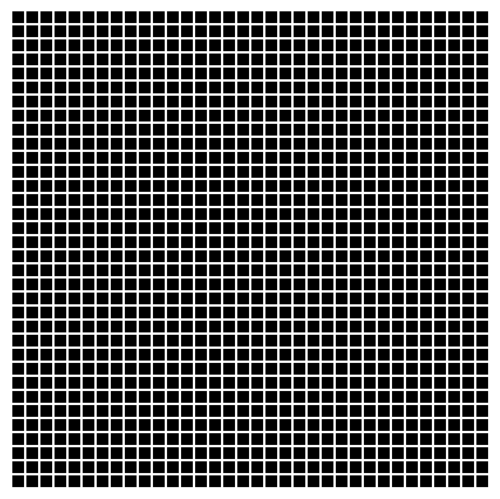

In [236]:
img_size = 1024
square_size = 30
line_thickness = 5  # Set the thickness of the lines

# Create a black image
grid_image = np.zeros((img_size, img_size))

# Draw white lines to create the grid
for i in range(0, img_size, square_size):
    for j in range(line_thickness):
        if i + j < img_size:
            grid_image[i + j, :] = 1  # Horizontal white line
            grid_image[:, i + j] = 1  # Vertical white line

# Display the grid image using matplotlib
plt.imshow(grid_image, cmap='gray')
plt.axis('off')  # Turn off axis numbers and ticks
plt.gca().set_position([0, 0, 1, 1])

(-0.5, 1023.5, 1023.5, -0.5)

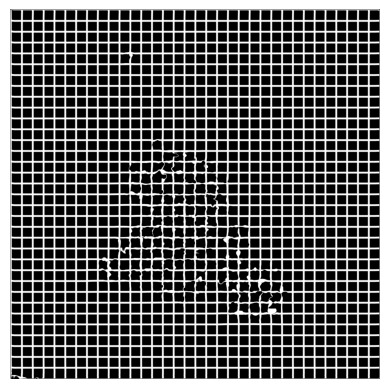

In [237]:
grid_image = grid_image[np.newaxis, ..., np.newaxis]
grid_image = torch.from_numpy(grid_image).to(device).float().permute(0, 3, 1, 2)
deformed_grid=best_model.transformer(grid_image,warp_field)
deformed_grid=deformed_grid.squeeze().cpu().detach().numpy()
#Plot the deformation field
plt.imshow(deformed_grid, cmap='gray')
plt.axis('off')